In [1]:
import json
import codecs

In [2]:
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import statistics as st

In [3]:
path = "E:\\PycharmProjects\\Dmitriev's Project\\"

In [34]:
def get_portion(last_pos):
    first = "H:/Вова/Partitions/first-debate_partition_{}.json".format(last_pos)
    second = "H:/Вова/Second debates/second-debate_partition_{}.txt".format(last_pos)
    local_data = []
    with open(second, "r+", encoding="utf-8") as partition_reader:
        partition = partition_reader.readlines()
        for line in partition:
            local_data.append(json.loads(line))
    last_pos += 1
    return local_data, last_pos

In [53]:
def patient_zero():
    number = 1
    last_pos = 4

    while last_pos != 5:
        tmp = get_portion(last_pos)

        local_data = tmp[0]
        last_pos = tmp[1]
        
        local_data = list(filter(lambda x: (not x['text'].startswith('RT')), local_data))
        local_data = list(filter(lambda x: (not x['text'].startswith("@{0}'s account".format(x['user']['screen_name']))), local_data))

        for tweet in local_data:
            with codecs.open("Level_0_{0}.txt".format(last_pos - 1), 'a', 'utf_8_sig') as file:
                file.write("{0}\n".format(json.dumps(
                    {"id": tweet['id'],
                     "number": number,
                     "screen_name": tweet['user']['screen_name'],
                     "retweet_count": tweet['retweet_count'],
                     "created_at": tweet["created_at"],
                     "full_text": tweet["text"]
                     })))
            number += 1

        print("Iteration: {0}, Number: {1}".format(last_pos - 1, number), end='\r')

In [54]:
def level_one():
    iteration = 1
    number = 1
    last_pos = 0

    with zip.ZipFile('first-debate.zip') as zf:
        size = zf.getinfo("first-debate.json").file_size

    zero = collect_zero()

    # zero = list(filter(lambda x: x["retweet_count"] > 49, zero))
    # zero = list(filter(lambda x: x['retweeted_status'] is not None, zero))

    while last_pos != size:
        tmp = get_portion(last_pos)

        local_data = tmp[0]
        last_pos = tmp[1]

        for item in zero:
            match = []
            for tweet in local_data:
                try:
                    if tweet['retweeted_status']['id'] == item['id']:
                        match.append(tweet)
                except KeyError:
                    pass

            for tweet in match:
                with codecs.open("Level_1_{0}.txt".format(last_pos - 1), 'a', 'utf_8_sig') as file:
                    file.write("{0}\n".format(json.dumps(
                        {"id": tweet['id'],
                         "number": number,
                         "number_pr": item["number"],
                         "screen_name": tweet['user']['screen_name'],
                         "retweet_count": tweet['retweet_count'],
                         "created_at": tweet["created_at"],
                         "full_text": tweet["text"]
                         })))
            number += 1
        print("Iteration: {0}, Number: {1}".format((last_pos - 1), number))

In [70]:
def collect_zero():
#     path + "Level_0_{0}.txt".format(i)
#     "H:/Вова/Second debates/Level_0_{}.txt".format(i)
    zero = []

    for i in range(1, 9):
        with open(path + "Level_0_{0}.txt".format(i), 'r') as fp:
            tmp = fp.readlines()
            for string in tmp:
                zero.append(json.loads(codecs.decode(string.encode(), "utf-8-sig").rstrip().replace("п»ї", "")))

    return zero

In [98]:
# Динамика числа ретвитов во времени
def Rt(zero): 
    x = []
    y = []
    count = {}

    for item in zero:
        tmp = datetime.strptime(item["created_at"], '%a %b %d %H:%M:%S +0000 %Y')
        if tmp in count.keys():
            count[tmp] += item["retweet_count"]
        else:
            count[tmp] = item["retweet_count"]

    for key, value in count.items():
        x.append(key)
        y.append(value)
    
    plt.figure(figsize=(19.20 * 2,10.80 * 2))
    plt.ylabel("Retweet count")
    plt.xlabel("Time, sec")
    plt.plot(x, y, label='Retweet dynamics timeseries')
    plt.savefig('Rt.png', format='png')
    plt.savefig('Rt.svg', format='svg')
    plt.savefig('Rt.eps', format='eps')
    plt.savefig('Rt.pdf', format='pdf')
    
    return x,y

In [94]:
# Число источников зарождения ретвитов
def Nt(zero):
    x = []
    y = []
    count = {}

    for item in zero:
        tmp = datetime.strptime(item["created_at"], '%a %b %d %H:%M:%S +0000 %Y')
        if tmp in count.keys():
            count[tmp] += 1
        else:
            count[tmp] = 1

    for key, value in count.items():
        x.append(key)
        y.append(value)
        
    plt.figure(figsize=(19.20 * 2,10.80 * 2))
    plt.ylabel("Retweet sourses count")
    plt.xlabel("Time, sec")
#     plt.fill_between(x, y, alpha=0.5)
    plt.plot(x, y, label="Retweet sourses timeseries")
    plt.legend(("Retweet sourses count", "Time, sec"))
    plt.savefig('Nt.png', format='png')
    plt.savefig('Nt.svg', format='svg')
    plt.savefig('Nt.eps', format='eps')
    plt.savefig('Nt.pdf', format='pdf')
    
    return x,y

In [95]:
# Статистически средняя длина цепочки
def R_Nt(x, y, X, Y):
    y = np.array(y, dtype=np.float)
    Y = np.array(Y, dtype=np.float)
    
    plt.figure(figsize=(19.20 * 2,10.80 * 2))
    plt.ylabel("R(t) / N(t)")
    plt.xlabel("Time, sec")
    plt.plot(x, y/Y, label='Retweet dynamics timeseries / Retweet sourses timeseries')
    plt.savefig('R_Nt.png', format='png')
    plt.savefig('R_Nt.svg', format='svg')
    plt.savefig('R_Nt.eps', format='eps')
    plt.savefig('R_Nt.pdf', format='pdf')

In [71]:
zero = collect_zero()

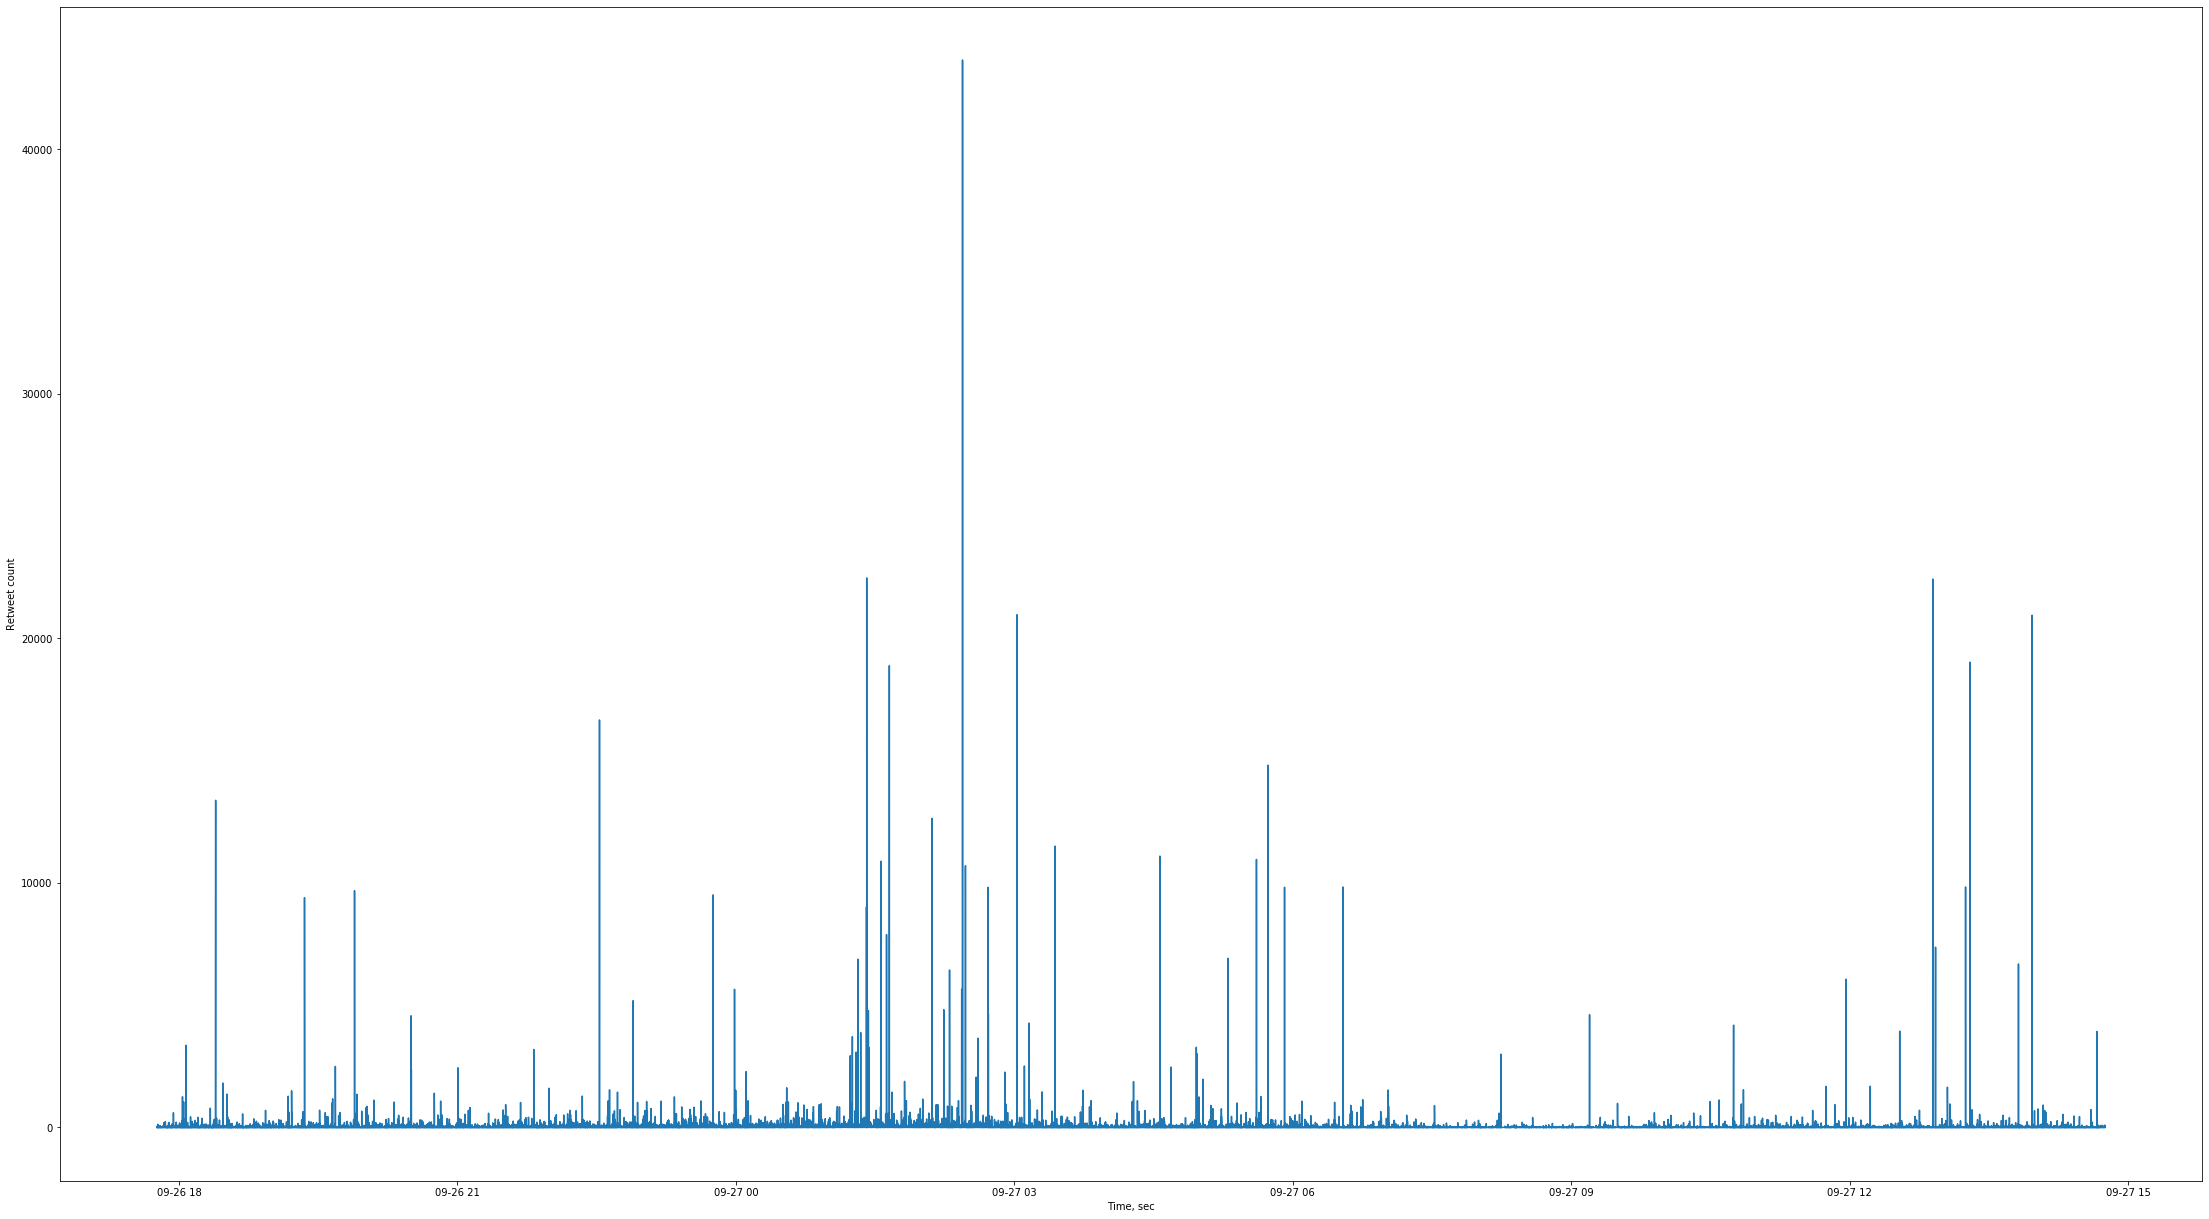

In [99]:
x, y = Rt(zero)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


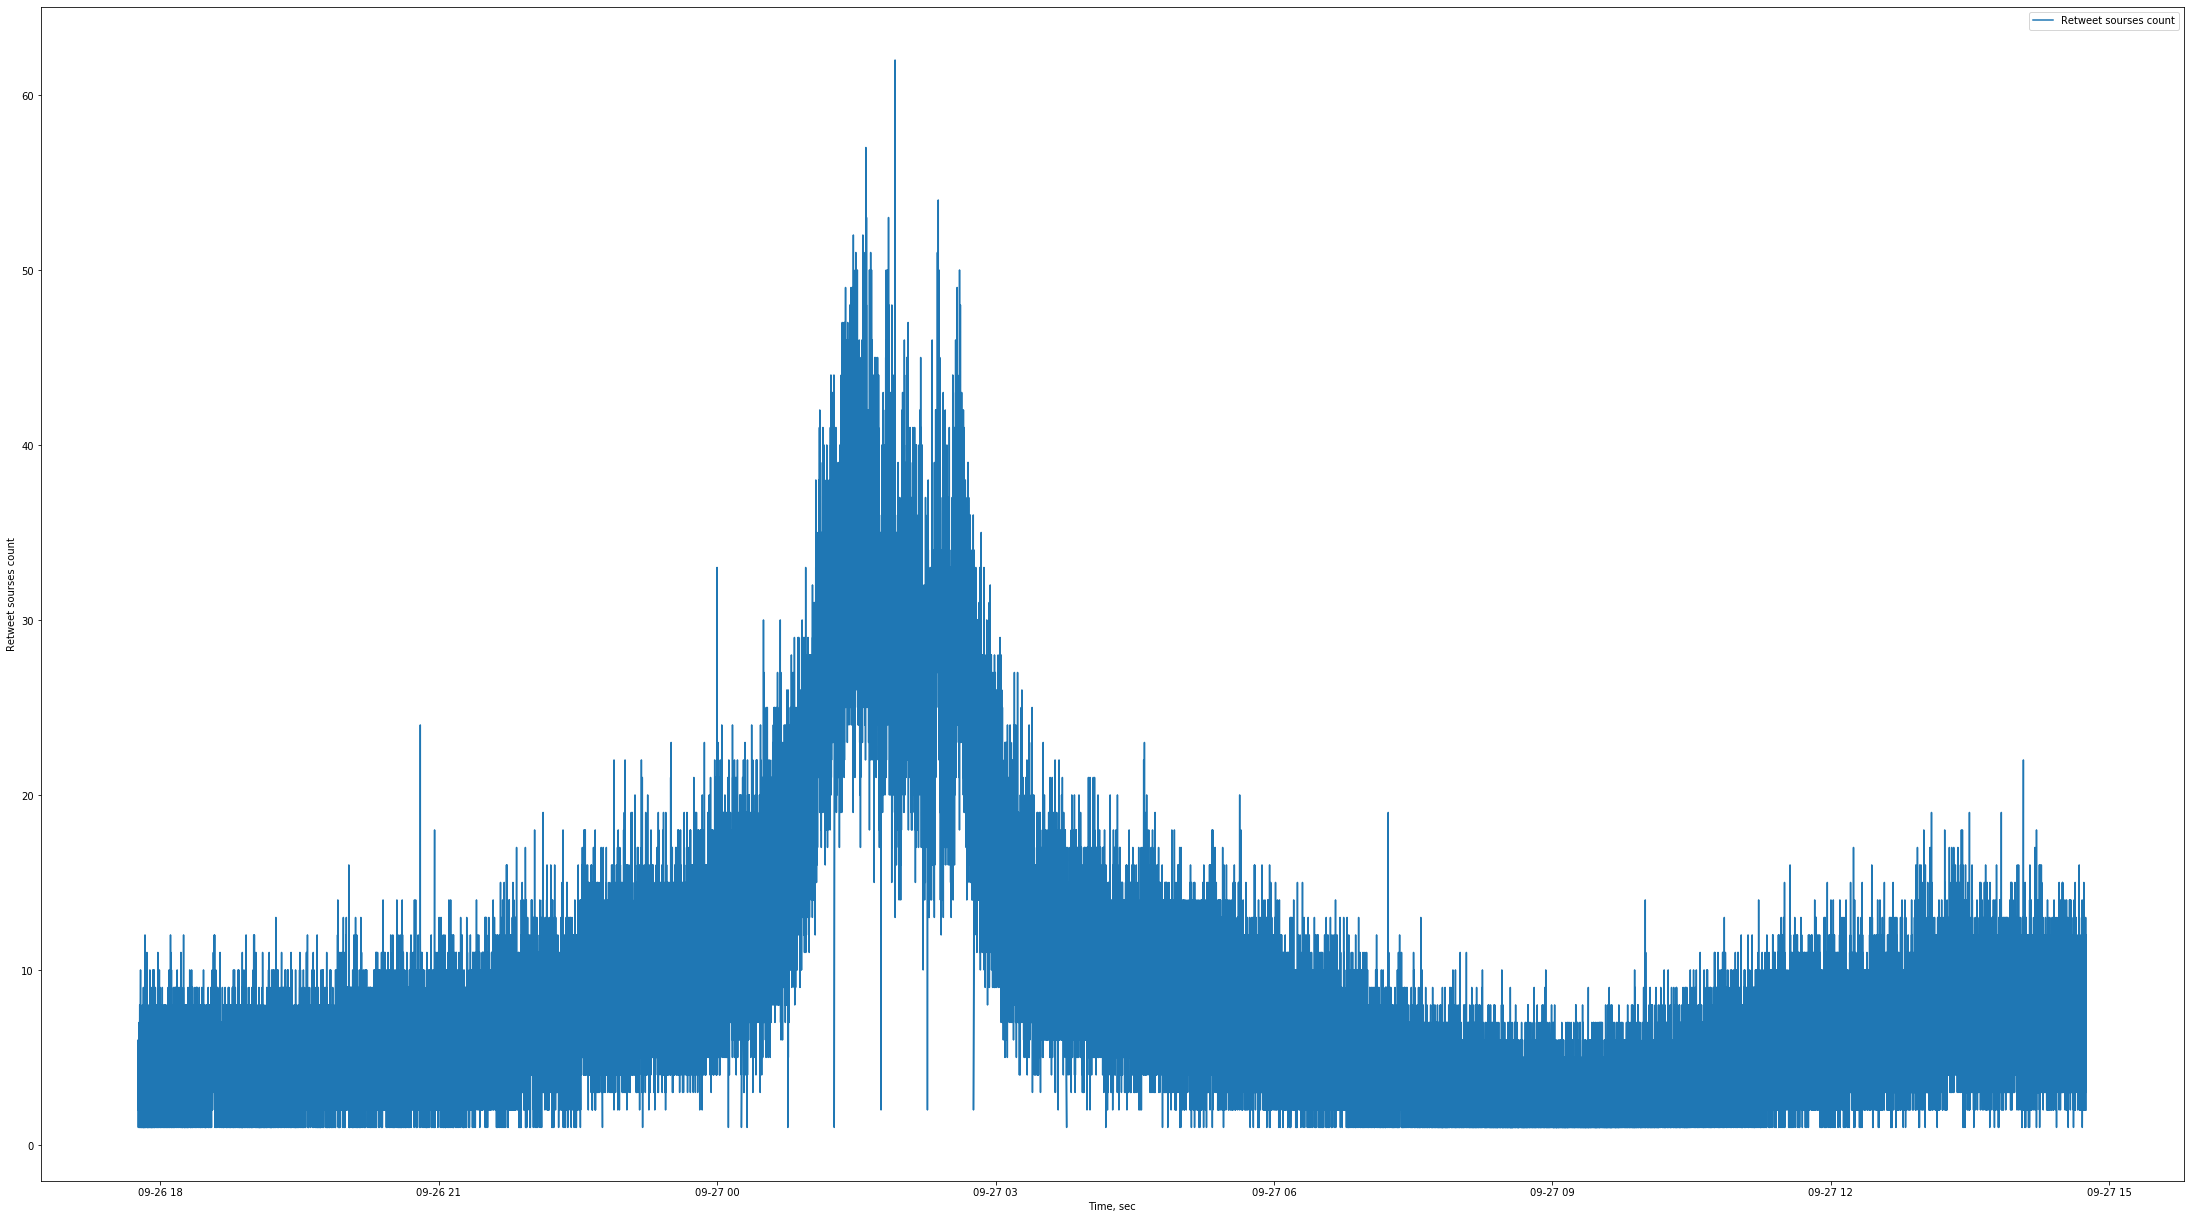

In [96]:
X, Y = Nt(zero)

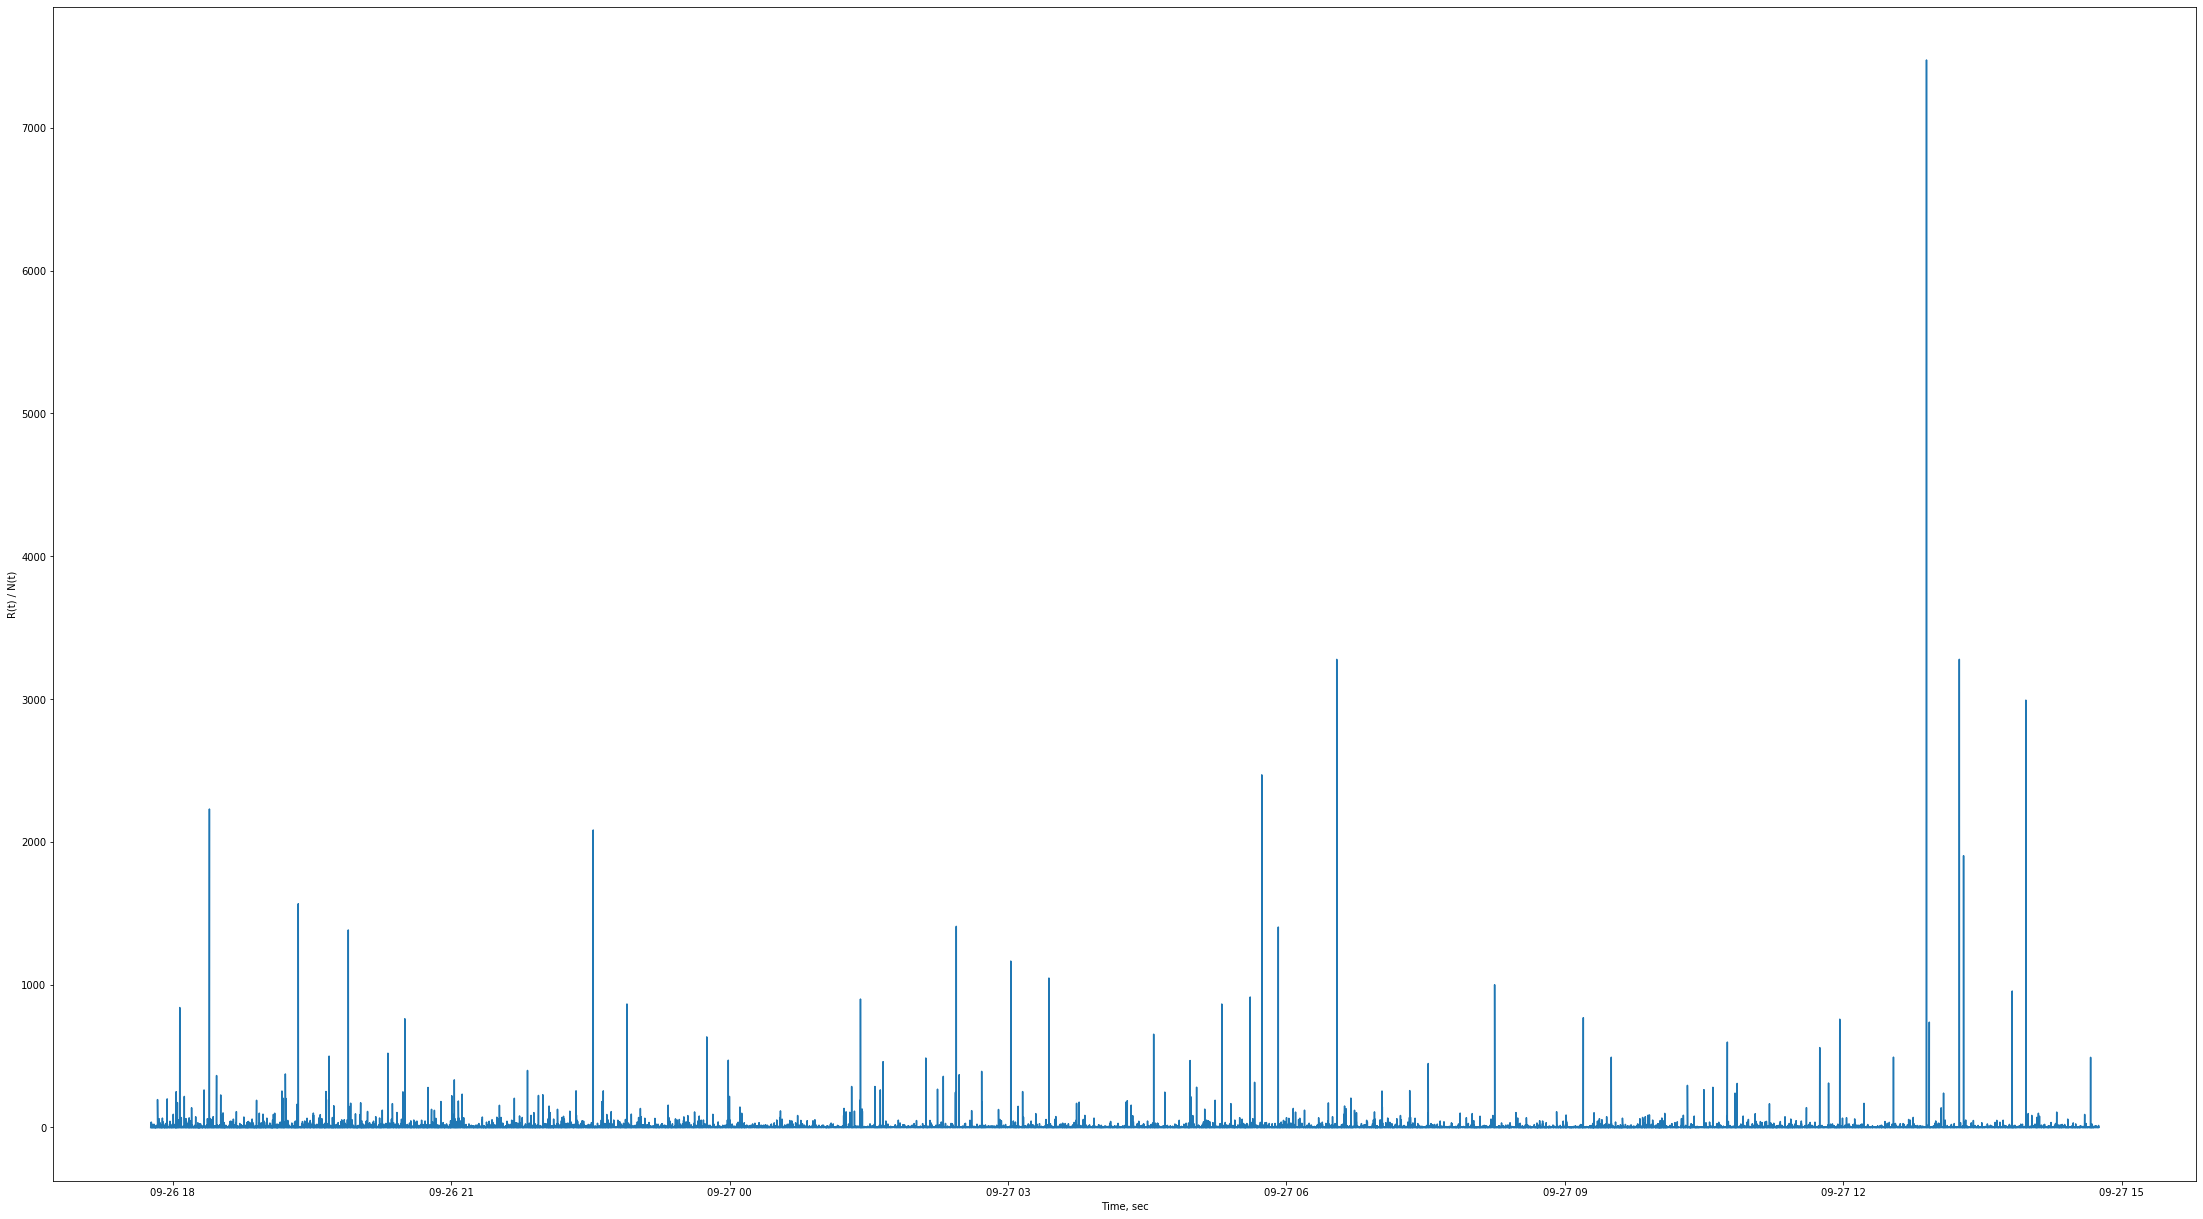

In [97]:
R_Nt(x, y, X, Y)